## **PA3**
####Team:

  - Diego Ordonez Pasaje
  - Maria Rossano
  - Tanwi Sarkar


####Name of Data Set:
  - Polycystic ovary syndrome (PCOS) 

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
# from sklearn.inspection import DecisionBoundaryDisplay
#Loading the modules required to build and evaluate a KNN model
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Data**

In [ ]:
# Load Original Data
PCOS_path = "../Datasets/"

PCOS_file = PCOS_path + "PCOS_data_without_infertility.xlsx"
PCOS = pd.read_excel(PCOS_file, sheet_name="Full_new")

# **0. Data Transformation and Feature Engineering**


In [ ]:
# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 1. Drop non-features/labels columns and misaligned column**
# columns to be droped
columns_drop =['Sl. No', 'Patient File No.', \
                'Unnamed: 44']

# labels name
# JUST FOR DATA TRANSFORMATION, VARIABLE WILL BE REDIRECTED LATER:
labels_name ='PCOS (Y/N)' 

# 1. Drop columns in `not_to_be_used`
PCOS.drop(columns_drop, axis=1, inplace=True)

# Check
display(PCOS.head())
display(PCOS.tail())

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 2. Address non float values**
### Feature 'AMH(ng/mL)' has a none float64 value in row: `305`
### Feature 'II    beta-HCG(mIU/mL)' has a none float64 value in row: `123`

# 2.  Address non float values in rows [305, 123].
# A. 
# Rest of values in PCOS.iloc[305] seem to be consistent w/neighbouring rows
#PCOS.iloc[[301, 302, 303, 304, 305]].T

# Thus, I suggest converting their value "a" into a nan
# and treat it as a missing value.
PCOS.replace(PCOS['AMH(ng/mL)'].iloc[305], np.nan, inplace=True)
PCOS['AMH(ng/mL)'] = pd.to_numeric(PCOS['AMH(ng/mL)'], errors = 'coerce')

# B.
# PCOS.iloc[[123, 124, 125]].T
# Seems to be an extra "." in the feature value "1.99.".
# Check with `PCOS['II    beta-HCG(mIU/mL)'].iloc[120:125].T`
PCOS.replace(PCOS['II    beta-HCG(mIU/mL)'].iloc[123], float(1.99), \
             inplace=True)
PCOS['II    beta-HCG(mIU/mL)'] = pd.to_numeric(PCOS['II    beta-HCG(mIU/mL)'],\
                                               errors='coerce')


# Check dtypes
PCOS.dtypes

# Check those specific feature values
print(f"\n305: {PCOS['AMH(ng/mL)'].iloc[305]}")
print(f"123: {PCOS['II    beta-HCG(mIU/mL)'].iloc[123]}\n")


# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 3. Drop outliers (i.e., rows with outliers)**

# 3. Drop outliers (i.e, rows with outliers):
rows_drop_dict = {"Pulse":[223, 296],
                  "BP_Systolic": [161], 
                  "BP_Diastolic": [200]}

drops = []
for val in rows_drop_dict.values():
  drops += val

PCOS.drop(drops, axis=0, inplace=True)

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 4. filling `Nan`'s values for specific rows**
# 305, 458, 156

# A. PCOS.iloc[[ 458]].T has a Nan value for the 'Marraige Status (Yrs)'
# This woman (PCOS.iloc[[ 458]]) has 36 year old
# So, we calculate the mean of 'Marraige Status (Yrs)' for those that only have 36 year old
# Then, we use this mean to fill the Nan value: 

age36Marraige = PCOS[PCOS[' Age (yrs)']==36]['Marraige Status (Yrs)'] # data points of women with 36 year all and their respective years of marriege
age36Marraige_mean = age36Marraige.mean() 
PCOS['Marraige Status (Yrs)'].fillna(age36Marraige_mean, inplace=True)

# B. PCOS.iloc[[ 156]].T has a Nan value for the 'Fast food (Y/N)'
# We fill this value with the mode of 'Fast food (Y/N)':

PCOS['Fast food (Y/N)'].fillna(PCOS['Fast food (Y/N)'].mode()[0], inplace=True)

# C. PCOS.iloc[[ 305]].T has a Nan value for the feature "AMH(ng/mL)"
mean_amh = PCOS["AMH(ng/mL)"].mean()
PCOS["AMH(ng/mL)"].fillna(mean_amh, inplace=True)

print(f"Now, Nan values in the coordinates (305, 'AMH(ng/mL)') is \
{PCOS['AMH(ng/mL)'].iloc[305]}") 

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 5. Reindex**
# Reset index of df
PCOS.reset_index(drop=True, inplace=True)


# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 6. Recalculate BMI and drop `BMI` column**
# Recalculate BMI
def get_bmi(row):
  w = row["Weight (Kg)"]
  h = float(row["Height(Cm) "])/100
  bmi = w/h**2
  return bmi

# Create a column with the recalculated BMI
PCOS["bmi_recalc"] = PCOS.apply(get_bmi, axis=1)

# Drop column
PCOS.drop("BMI", axis=1, inplace=True)
PCOS.columns


,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,10.48,2.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,11.70,2.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,11.80,2.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,12.00,2.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,10.00,2.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
536,0.0,35.0,50.0,164.592,18.5,17.0,72.0,16.0,11.0,2.0,...,0.0,0.0,0.0,110.0,70.0,1.0,0.0,17.5,10.0,6.7
537,0.0,30.0,63.2,158.000,25.3,15.0,72.0,18.0,10.8,2.0,...,0.0,0.0,0.0,110.0,70.0,9.0,7.0,19.0,18.0,8.2
538,0.0,36.0,54.0,152.000,23.4,13.0,74.0,20.0,10.8,2.0,...,0.0,0.0,0.0,110.0,80.0,1.0,0.0,18.0,9.0,7.3
539,0.0,27.0,50.0,150.000,22.2,15.0,74.0,20.0,12.0,4.0,...,1.0,0.0,0.0,110.0,70.0,7.0,6.0,18.0,16.0,11.5
540,1.0,23.0,82.0,165.000,30.1,13.0,80.0,20.0,10.2,4.0,...,1.0,1.0,0.0,120.0,70.0,9.0,10.0,19.0,18.0,6.9



305: nan
123: 1.99

Now, Nan values in the coordinates (305, 'AMH(ng/mL)') is 1.5


Index(['PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'Blood Group',
       'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)',
       'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)',
       'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)',
       'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)',
       'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'bmi_recalc'],
      dtype='object')

In [ ]:
# Final check
print(f"Total of null values: {PCOS.isnull().sum().sum()}\n")

print(f"dtypes for all columns:\n{PCOS.dtypes}")

Total of null values: 0

dtypes for all columns:
PCOS (Y/N)                float64
 Age (yrs)                float64
Weight (Kg)               float64
Height(Cm)                float64
Blood Group               float64
Pulse rate(bpm)           float64
RR (breaths/min)          float64
Hb(g/dl)                  float64
Cycle(R/I)                float64
Cycle length(days)        float64
Marraige Status (Yrs)     float64
Pregnant(Y/N)             float64
No. of aborptions         float64
  I   beta-HCG(mIU/mL)    float64
II    beta-HCG(mIU/mL)    float64
FSH(mIU/mL)               float64
LH(mIU/mL)                float64
FSH/LH                    float64
Hip(inch)                 float64
Waist(inch)               float64
Waist:Hip Ratio           float64
TSH (mIU/L)               float64
AMH(ng/mL)                float64
PRL(ng/mL)                float64
Vit D3 (ng/mL)            float64
PRG(ng/mL)                float64
RBS(mg/dl)                float64
Weight gain(Y/N)          float64

# **Beginning of tasks of assignment PA3**

In [ ]:
PCOS.columns

Index(['PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'Blood Group',
       'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)',
       'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)',
       'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)',
       'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)',
       'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'bmi_recalc'],
      dtype='object')

In [ ]:
# Split features into two groups, categorical and numerical

columns_names = PCOS.columns
labels_name = "PCOS (Y/N)"

features_categ = []
features_numeric = []

for column in columns_names:
  unq = PCOS[column].unique()
  if column != labels_name:
    if len(unq) <= 3 or (column == "Blood Group"):
      features_categ.append(column)
    else:
      features_numeric.append(column)


features_all = features_categ + features_numeric

# Display features names
display(features_categ)
display(features_numeric)
print(f"Features total: {len(features_all)}")

['Blood Group',
 'Cycle(R/I)',
 'Pregnant(Y/N)',
 'Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Hair loss(Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'Reg.Exercise(Y/N)']

[' Age (yrs)',
 'Weight (Kg)',
 'Height(Cm) ',
 'Pulse rate(bpm) ',
 'RR (breaths/min)',
 'Hb(g/dl)',
 'Cycle length(days)',
 'Marraige Status (Yrs)',
 'No. of aborptions',
 '  I   beta-HCG(mIU/mL)',
 'II    beta-HCG(mIU/mL)',
 'FSH(mIU/mL)',
 'LH(mIU/mL)',
 'FSH/LH',
 'Hip(inch)',
 'Waist(inch)',
 'Waist:Hip Ratio',
 'TSH (mIU/L)',
 'AMH(ng/mL)',
 'PRL(ng/mL)',
 'Vit D3 (ng/mL)',
 'PRG(ng/mL)',
 'RBS(mg/dl)',
 'BP _Systolic (mmHg)',
 'BP _Diastolic (mmHg)',
 'Follicle No. (L)',
 'Follicle No. (R)',
 'Avg. F size (L) (mm)',
 'Avg. F size (R) (mm)',
 'Endometrium (mm)',
 'bmi_recalc']

Features total: 41


## **Feature Enconding**

In [ ]:
features_categ_rename = ['Blood_Group',
 'Cycle(R/I)',
 'Pregnant(Y/N)',
  'Weight_gain(Y/N)',
 'hair_growth(Y/N)',
 'Skin_darkening (Y/N)',
 'Hair_loss(Y/N)',
 'Pimples(Y/N)',
 'Fast_food_(Y/N)',
 'Reg_Exercise(Y/N)']

features_categ_rename = ["enc_" + feature.lower() for feature in features_categ_rename]


PCOS = pd.get_dummies(PCOS, columns=features_categ, prefix=features_categ_rename)


# **1. Feature Scaling**

## **1.1.a Check extreme values**

In [ ]:
# Extreme values for all numerical features
# All numerical values need to be included so we can determine "numerically" 
# what are the outliers in section 1.2.b
for feature in features_numeric:
  fig = px.box(PCOS, y=feature,
               points='all',
               title=f"{feature}",
               ) 
  fig.update_layout(title_font_size=25)
  fig.show()


## **1.1.b Check extreme values**

In [ ]:
# Get outliers:
# modified from https://www.geeksforgeeks.org/how-to-use-pandas-filter-with-iqr/

print(f"Features with no. of outliers < 5% of examples:")
for feature in features_numeric:
  Q3 = PCOS[feature].quantile(q=0.75)
  Q1 = PCOS[feature].quantile(q=0.25)
  IQR = Q3-Q1

  low_fence = Q1 - 1.5*IQR
  up_fence = Q3 + 1.5*IQR

  total_rows = PCOS.shape[0]
  up_out = PCOS[feature][PCOS[feature] > up_fence]
  low_out = PCOS[PCOS[feature] < low_fence]
  
  # Get arrays of outliers indices and values
  all_out_idx = np.append(up_out.index.values, low_out.index.values)
  all_out_vals = np.append(up_out.values, low_out.values)

  
  percent_outliers = len(all_out_idx)*100/total_rows
  if percent_outliers > 5.:
    print(f"{feature}\n")
    print(f"Outliers values: \n {all_out_vals}\n")
    print(f"{'--'*20}")



Features with no. of outliers < 5% of examples:
Pulse rate(bpm) 

Outliers values: 
 [78. 78. 80. 80. 78. 80. 80. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 80.
 78. 78. 80. 80. 80. 80. 78. 80. 78. 78. 80. 78. 78. 78. 78. 78. 80. 78.
 78. 78. 80. 80. 78. 78. 82. 78. 80. 78. 78. 78. 78. 78. 78. 80. 80. 78.
 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 80. 78. 78. 82. 80. 78. 78. 78.
 80. 78. 78. 82. 80. 78. 80. 78. 78. 80. 80. 78. 78. 80. 80. 80. 80. 78.
 78. 80.]

----------------------------------------
Cycle length(days)

Outliers values: 
 [7. 9. 7. ... 0. 1. 0.]

----------------------------------------
No. of aborptions

Outliers values: 
 [2. 1. 2. 1. 3. 1. 1. 1. 3. 1. 2. 2. 2. 1. 3. 2. 3. 5. 1. 1. 1. 1. 4. 1.
 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 2. 1. 1. 1. 2. 1. 4. 1. 2.
 1. 3. 1. 2. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 1. 1.
 1. 1. 3. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 3. 1.
 1. 1. 1. 2. 1. 1. 1.]

---------------------------------------

## **1.2. Min-max scale data**

In [ ]:
# Select data
columns_names = PCOS.columns
X = PCOS[columns_names[1:]]
y = PCOS[labels_name]

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# y_train.head()

In [ ]:
# Apply min-max scaling

X_train_minmax, X_test_minmax = X_train.copy(), X_test.copy()
X_train_standard, X_test_standard = X_train.copy(), X_test.copy()

def get_minmax_scaled(df, feature, scaler_type):
  scaler = scaler_type()
  feature_scaled = scaler.fit_transform(df[[feature]].values)
  feature_scaled = (2 * feature_scaled) - 1
  df[feature] = feature_scaled
  return df

for feature in features_numeric:
  get_minmax_scaled(X_train_minmax, feature, MinMaxScaler)
  get_minmax_scaled(X_test_minmax, feature, MinMaxScaler)



In [ ]:
display(X_train.head())
display(X_train_minmax.head())
# display(X_test.head())


,Age (yrs),Weight (Kg),Height(Cm),Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle length(days),Marraige Status (Yrs),No. of aborptions,I beta-HCG(mIU/mL),...,enc_skin_darkening (y/n)_0.0,enc_skin_darkening (y/n)_1.0,enc_hair_loss(y/n)_0.0,enc_hair_loss(y/n)_1.0,enc_pimples(y/n)_0.0,enc_pimples(y/n)_1.0,enc_fast_food_(y/n)_0.0,enc_fast_food_(y/n)_1.0,enc_reg_exercise(y/n)_0.0,enc_reg_exercise(y/n)_1.0
472,32.0,61.0,165.0,78.0,20.0,11.5,5.0,1.5,0.0,1.97,...,1,0,1,0,1,0,1,0,0,1
227,40.0,71.0,152.0,72.0,18.0,13.2,5.0,7.0,0.0,1.99,...,1,0,0,1,1,0,0,1,1,0
245,33.0,65.0,153.0,72.0,18.0,12.0,5.0,1.0,0.0,1.99,...,0,1,1,0,0,1,0,1,1,0
421,37.0,59.0,148.0,74.0,20.0,10.8,3.0,4.0,0.0,1.99,...,0,1,1,0,0,1,0,1,1,0
19,30.0,85.0,165.0,72.0,18.0,12.5,7.0,7.0,0.0,23.58,...,0,1,0,1,0,1,0,1,1,0


,Age (yrs),Weight (Kg),Height(Cm),Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle length(days),Marraige Status (Yrs),No. of aborptions,I beta-HCG(mIU/mL),...,enc_skin_darkening (y/n)_0.0,enc_skin_darkening (y/n)_1.0,enc_hair_loss(y/n)_0.0,enc_hair_loss(y/n)_1.0,enc_pimples(y/n)_0.0,enc_pimples(y/n)_1.0,enc_fast_food_(y/n)_0.0,enc_fast_food_(y/n)_1.0,enc_reg_exercise(y/n)_0.0,enc_reg_exercise(y/n)_1.0
472,-0.111111,-0.178082,0.302326,0.333333,-0.333333,-0.047619,-0.4,-0.965517,-1.0,-0.999995,...,1,0,1,0,1,0,1,0,0,1
227,0.481481,0.095890,-0.302326,-0.666667,-0.666667,0.492063,-0.4,-0.586207,-1.0,-0.999994,...,1,0,0,1,1,0,0,1,1,0
245,-0.037037,-0.068493,-0.255814,-0.666667,-0.666667,0.111111,-0.4,-1.000000,-1.0,-0.999994,...,0,1,1,0,0,1,0,1,1,0
421,0.259259,-0.232877,-0.488372,-0.333333,-0.333333,-0.269841,-0.8,-0.793103,-1.0,-0.999994,...,0,1,1,0,0,1,0,1,1,0
19,-0.259259,0.479452,0.302326,-0.666667,-0.666667,0.269841,0.0,-0.586207,-1.0,-0.998664,...,0,1,0,1,0,1,0,1,1,0


## **1.3 Standardize**

In [ ]:
def get_std_scaled(df, feature, scaler_type):
  scaler = scaler_type()
  feature_scaled = scaler.fit_transform(df[[feature]].values)
  df[feature] = feature_scaled
  return df

for feature in features_numeric:
  get_std_scaled(X_train_standard, feature, StandardScaler)
  get_std_scaled(X_test_standard, feature, StandardScaler)


In [ ]:
display(X_train_standard.head())
display(X_train_standard.describe())

,Age (yrs),Weight (Kg),Height(Cm),Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle length(days),Marraige Status (Yrs),No. of aborptions,I beta-HCG(mIU/mL),...,enc_skin_darkening (y/n)_0.0,enc_skin_darkening (y/n)_1.0,enc_hair_loss(y/n)_0.0,enc_hair_loss(y/n)_1.0,enc_pimples(y/n)_0.0,enc_pimples(y/n)_1.0,enc_fast_food_(y/n)_0.0,enc_fast_food_(y/n)_1.0,enc_reg_exercise(y/n)_0.0,enc_reg_exercise(y/n)_1.0
472,0.121403,0.116892,1.470590,1.842145,0.419858,0.384741,0.028449,-1.317553,-0.4201,-0.200616,...,1,0,1,0,1,0,1,0,0,1
227,1.646531,1.059156,-0.762310,-0.520031,-0.732244,2.363313,0.028449,-0.130851,-0.4201,-0.200611,...,1,0,0,1,1,0,0,1,1,0
245,0.312044,0.493798,-0.590549,-0.520031,-0.732244,0.966674,0.028449,-1.425435,-0.4201,-0.200611,...,0,1,1,0,0,1,0,1,1,0
421,1.074608,-0.071560,-1.449356,0.267361,0.419858,-0.429964,-1.317002,-0.778143,-0.4201,-0.200611,...,0,1,1,0,0,1,0,1,1,0
19,-0.259879,2.378326,1.470590,-0.520031,-0.732244,1.548607,1.373899,-0.130851,-0.4201,-0.194679,...,0,1,0,1,0,1,0,1,1,0


,Age (yrs),Weight (Kg),Height(Cm),Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle length(days),Marraige Status (Yrs),No. of aborptions,I beta-HCG(mIU/mL),...,enc_skin_darkening (y/n)_0.0,enc_skin_darkening (y/n)_1.0,enc_hair_loss(y/n)_0.0,enc_hair_loss(y/n)_1.0,enc_pimples(y/n)_0.0,enc_pimples(y/n)_1.0,enc_fast_food_(y/n)_0.0,enc_fast_food_(y/n)_1.0,enc_reg_exercise(y/n)_0.0,enc_reg_exercise(y/n)_1.0
count,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,...,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,1.104700e-16,-7.224735e-16,5.700250e-16,1.281451e-15,3.269911e-16,-2.651279e-17,-1.237263e-16,1.347733e-16,6.628197e-18,-2.209399e-18,...,0.679104,0.320896,0.534826,0.465174,0.497512,0.502488,0.467662,0.532338,0.738806,0.261194
std,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,1.001246e+00,...,0.467402,0.467402,0.499407,0.499407,0.500617,0.500617,0.499575,0.499575,0.439833,0.439833
min,-2.166289e+00,-2.709899e+00,-3.338733e+00,-1.307424e+00,-1.884347e+00,-3.106855e+00,-1.989728e+00,-1.425435e+00,-4.201003e-01,-2.006382e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.411608e-01,-6.369188e-01,-7.623102e-01,-5.200315e-01,-7.322443e-01,-6.627374e-01,2.844859e-02,-7.781429e-01,-4.201003e-01,-2.006108e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.923778e-02,2.266590e-02,1.061674e-02,-5.200315e-01,-7.322443e-01,-1.971912e-01,2.844859e-02,-1.308506e-01,-4.201003e-01,-1.948962e-01,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,6.933262e-01,4.937978e-01,6.117822e-01,2.673608e-01,4.198583e-01,6.175146e-01,2.844859e-02,5.164417e-01,-4.201003e-01,-1.149425e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.981018e+00,4.168627e+00,4.047013e+00,3.416930e+00,5.028268e+00,4.225497e+00,4.737526e+00,4.831724e+00,6.797007e+00,8.717116e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **1.4. Vis Comparison 1**

In [ ]:
vis_comp_features = ['Vit D3 (ng/mL)', 'PRG(ng/mL)','RBS(mg/dl)']

dfs = [X_test_minmax, X_test_standard]
for df in dfs:
  for feature in vis_comp_features:
    mean = round(df[feature].mean(), 4)
    std = round(df[feature].std(), 4)
    min = round(df[feature].min(), 2)
    max = round(df[feature].max(), 2)
    print(f"{feature:15} {'*'*5} Min: {min:6} Max: {max:6} {'*'*5} Mean: {mean:7} {'*'*5} STD: {std:5}")

Vit D3 (ng/mL)  ***** Min:   -1.0 Max:    1.0 ***** Mean: -0.1957 ***** STD: 0.4186
PRG(ng/mL)      ***** Min:   -1.0 Max:    1.0 ***** Mean: -0.4654 ***** STD: 0.3844
RBS(mg/dl)      ***** Min:   -1.0 Max:    1.0 ***** Mean: -0.7889 ***** STD: 0.1829
Vit D3 (ng/mL)  ***** Min:  -1.93 Max:   2.87 ***** Mean:    -0.0 ***** STD: 1.0037
PRG(ng/mL)      ***** Min:   -1.4 Max:   3.83 ***** Mean:     0.0 ***** STD: 1.0037
RBS(mg/dl)      ***** Min:  -1.16 Max:   9.81 ***** Mean:    -0.0 ***** STD: 1.0037


Min-max scaling: the scaled values concentrate around the mean (small STD). 
Standardize: the scaled values are far from the mean (large STD).

## **1.5. Vis Comparison 2**
### **Test data**

In [ ]:
# Test data
dfs_labels = ["Non-scaled", "Min-max", "Standard"]
dfs = [X_test, X_test_minmax, X_test_standard]

for feature in features_numeric:
  for df_idx, df in enumerate(dfs):
    title = f"{feature} in {dfs_labels[df_idx]}"
    fig = px.box(df, y=feature, width=300, height=300, title=title)
    fig.show()

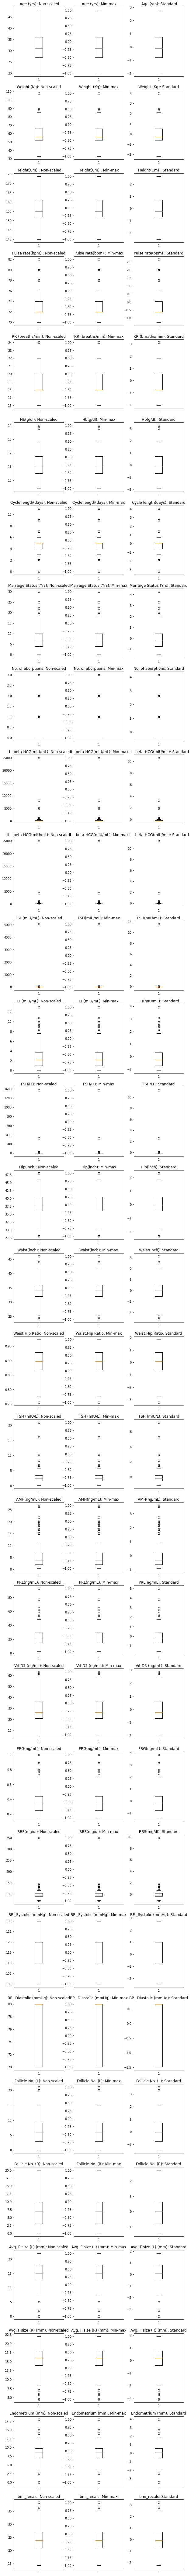

In [ ]:
# Usiing Matplotlib
rows = len(features_numeric)

fig = plt.figure(figsize=(10, rows*5))

dfs_labels = ["Non-scaled", "Min-max", "Standard"]
c=1
for feature_idx, feature in enumerate(features_numeric):
  for df_idx, df in enumerate(dfs):
    plt.subplot(rows, 3, c)
    plt.title(f"{feature}: {dfs_labels[df_idx]}")
    plt.boxplot(df[feature])
    c +=1

plt.show()


- The main chunk of the data in `Vit D3` and `PRG` are within similar ranges, i.e., `0-2`. Meaning, that standardization handles better outliers, as expected.

# **2. k-NN**

In [ ]:
k_list = [5,11,15]
weights_list = ['uniform', 'distance']
scores_list_nonScaled = []
scores_list_MinMax = []
scores_list_Standard = []

In [ ]:
def evaluate_model(featTr, labTr, feaTest, scores_list):
    KNN_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    KNN_model.fit(featTr, labTr)
    pred = KNN_model.predict(feaTest)
    scores_list.append({
                'Accuracy': round(accuracy_score(y_test, pred), 6),
                'precision': round(precision_score(y_test, pred), 3),
                'recall': round(recall_score(y_test, pred), 3),
                'aucs' : round(roc_auc_score(y_test, pred), 3),
                'F1score': round(f1_score(y_test, pred), 3),
                'K_values': n_neighbors,
                'weights': weights
            })

In [ ]:
for n_neighbors in k_list:
  for weights in weights_list:
    evaluate_model(X_train, y_train, X_test, scores_list_nonScaled)
results_nonScaled = pd.DataFrame(scores_list_nonScaled)
results_nonScaled = results_nonScaled.sort_values(by='Accuracy', ascending=False)

# Create a column to state that these result are from non scaled data
nonScaled_data = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
MinMax_data = ['No', 'No', 'No', 'No', 'No', 'No']
Standard_data = ['No', 'No', 'No', 'No', 'No', 'No']

results_nonScaled['NonScaled'] = nonScaled_data  
results_nonScaled['MinMax'] = MinMax_data 
results_nonScaled['Standard'] = Standard_data
results_nonScaled

,Accuracy,precision,recall,aucs,F1score,K_values,weights,NonScaled,MinMax,Standard
5,0.688889,1.000,0.143,0.571,0.250,15,distance,Yes,No,No
4,0.681481,1.000,0.122,0.561,0.218,15,uniform,Yes,No,No
1,0.674074,0.619,0.265,0.586,0.371,5,distance,Yes,No,No
3,0.674074,0.692,0.184,0.569,0.290,11,distance,Yes,No,No
0,0.666667,0.600,0.245,0.576,0.348,5,uniform,Yes,No,No
2,0.659259,0.667,0.122,0.544,0.207,11,uniform,Yes,No,No


In [ ]:
for n_neighbors in k_list:
  for weights in weights_list:
    evaluate_model(X_train_minmax, y_train, X_test_minmax, scores_list_MinMax)
results_MinMax = pd.DataFrame(scores_list_MinMax)
results_MinMax = results_MinMax.sort_values(by='Accuracy', ascending=False)

# Create a column to state that these result are from results_MinMax
MinMax_data = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
Standard_data = ['No', 'No', 'No', 'No', 'No', 'No']
nonScaled_data = ['No', 'No', 'No', 'No', 'No', 'No']

results_MinMax['NonScaled'] = nonScaled_data 
results_MinMax['MinMax'] = MinMax_data 
results_MinMax['Standard'] = Standard_data
results_MinMax

,Accuracy,precision,recall,aucs,F1score,K_values,weights,NonScaled,MinMax,Standard
2,0.859259,0.969,0.633,0.811,0.765,11,uniform,No,Yes,No
3,0.859259,0.969,0.633,0.811,0.765,11,distance,No,Yes,No
4,0.837037,0.966,0.571,0.780,0.718,15,uniform,No,Yes,No
5,0.837037,0.966,0.571,0.780,0.718,15,distance,No,Yes,No
0,0.829630,0.861,0.633,0.787,0.729,5,uniform,No,Yes,No
1,0.829630,0.861,0.633,0.787,0.729,5,distance,No,Yes,No


In [ ]:
for n_neighbors in k_list:
  for weights in weights_list:
    evaluate_model(X_train_standard, y_train, X_test_standard, scores_list_Standard)
results_Standard = pd.DataFrame(scores_list_Standard)
results_Standard = results_Standard.sort_values(by='Accuracy', ascending=False)

# Create a column to state that these result are from results_Standard
Standard_data = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
nonScaled_data = ['No', 'No', 'No', 'No', 'No', 'No']
MinMax_data = ['No', 'No', 'No', 'No', 'No', 'No']

results_Standard['NonScaled'] = nonScaled_data 
results_Standard['MinMax'] = MinMax_data 
results_Standard['Standard'] = Standard_data
results_Standard

,Accuracy,precision,recall,aucs,F1score,K_values,weights,NonScaled,MinMax,Standard
0,0.851852,0.914,0.653,0.809,0.762,5,uniform,No,No,Yes
1,0.851852,0.914,0.653,0.809,0.762,5,distance,No,No,Yes
2,0.844444,0.967,0.592,0.790,0.734,11,uniform,No,No,Yes
3,0.844444,0.967,0.592,0.790,0.734,11,distance,No,No,Yes
4,0.837037,0.966,0.571,0.780,0.718,15,uniform,No,No,Yes
5,0.837037,0.966,0.571,0.780,0.718,15,distance,No,No,Yes


In [ ]:
frames = [results_nonScaled, results_MinMax, results_Standard]
data_scores = pd.concat(frames).sort_values(by='Accuracy', ascending=False)
data_scores

,Accuracy,precision,recall,aucs,F1score,K_values,weights,NonScaled,MinMax,Standard
2,0.859259,0.969,0.633,0.811,0.765,11,uniform,No,Yes,No
3,0.859259,0.969,0.633,0.811,0.765,11,distance,No,Yes,No
0,0.851852,0.914,0.653,0.809,0.762,5,uniform,No,No,Yes
1,0.851852,0.914,0.653,0.809,0.762,5,distance,No,No,Yes
3,0.844444,0.967,0.592,0.790,0.734,11,distance,No,No,Yes
2,0.844444,0.967,0.592,0.790,0.734,11,uniform,No,No,Yes
5,0.837037,0.966,0.571,0.780,0.718,15,distance,No,Yes,No
4,0.837037,0.966,0.571,0.780,0.718,15,uniform,No,No,Yes
5,0.837037,0.966,0.571,0.780,0.718,15,distance,No,No,Yes
4,0.837037,0.966,0.571,0.780,0.718,15,uniform,No,Yes,No


In [ ]:
# #don run this plesase
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import ListedColormap
# from sklearn import neighbors, datasets
# from sklearn.inspection import DecisionBoundaryDisplay

# def evaluate_model(featTr, labTr, feaTest, scores_list):
#     KNN_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
#     KNN_model.fit(featTr, labTr)
#     pred = KNN_model.predict(feaTest)
#     scores_list.append({
#                 'Accuracy': round(accuracy_score(y_test, pred), 6),
#                 'precision': round(precision_score(y_test, pred), 3),
#                 'recall': round(recall_score(y_test, pred), 3),
#                 'aucs' : round(roc_auc_score(y_test, pred), 3),
#                 'F1score': round(f1_score(y_test, pred), 3),
#                 'K_values': n_neighbors,
#                 'weights': weights
#             })
#      _, ax = plt.subplots()
#     DecisionBoundaryDisplay.from_estimator(
#         KNN_model,
#         featTr,
#         cmap=cmap_light,
#         ax=ax,
#         response_method="predict",
#         plot_method="pcolormesh",
#         xlabel=PCOS.feature_names[0],
#         ylabel=PCOS.feature_names[1],
#         shading="auto",
#     )

#      # Plot also the training points
#     sns.scatterplot(
#         x=featTr[:, 0],
#         y=featTr[:, 1],
#         hue=iris.target_names[y],
#         palette=cmap_bold,
#         alpha=1.0,
#         edgecolor="black",
#     )
#     plt.title(
#         "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
#     )
#     plt.show()


In [ ]:

def get_bound_plots(weights_type, k):

  display(k)

  ####
  knn_forvis = KNeighborsClassifier(n_neighbors=k, weights=weights_type)

  # Train with 2 features
  two_features = [" Age (yrs)", "Height(Cm) "]
  X2_train_minmax = X_train_minmax[two_features]
  X2_test_minmax = X_test_minmax[two_features]

  knn_forvis.fit(X2_train_minmax, y_train)
  yhat_test_minmax = knn_forvis.predict(X2_test_minmax)

  # Get mesh for prediction
  # get ranges of data
  x_mins = np.min(X2_train_minmax, axis=0)
  x_maxs = np.max(X_train_minmax, axis=0)

  # # Get grid
  x0_vis_range = np.arange(x_mins[0] - 0.1, x_maxs[0] + 0.1, .01)
  x1_vis_range = np.arange(x_mins[1] - 0.1, x_maxs[1] + 0.1, .01)
  XX0_vis, XX1_vis = np.meshgrid(x0_vis_range, x1_vis_range)
  X_vis = np.c_[XX0_vis.flatten(), XX1_vis.flatten()]

  yhat_vis = knn_forvis.predict(X_vis)
  YYhat_vis = yhat_vis.reshape(XX0_vis.shape)


  ####

  fig = go.Figure()
  fig.add_trace(go.Heatmap(z=YYhat_vis, 
                          x=x0_vis_range,
                          y=x1_vis_range,
                          showscale=False))

  fig.add_trace(go.Scatter(x=X2_train_minmax[" Age (yrs)"],
                          y=X2_train_minmax["Height(Cm) "],
                          mode='markers',
                          marker=dict(
                              size=10,
                              line=dict(color='Red',
                                        width=2)),
                          marker_color=y_train, 
                          name="y_train",))

  fig.add_trace(go.Scatter(x=X2_test_minmax[" Age (yrs)"],
                          y=X2_test_minmax["Height(Cm) "],
                          mode='markers',
                          marker=dict(
                              size=10,
                              line=dict(color='Green',
                                        width=2)),
                          marker_color=yhat_test_minmax,
                          marker_line_width=3,
                          name="yhat_test"))

  fig.update_layout(showlegend=True,
                    title="`weights='Uniform'`")
  fig.update_xaxes(range=[x_mins[0] - 0.1, x_maxs[0] + 0.1],
                  title=" Age (yrs)")
  fig.update_yaxes(range=[x_mins[1] - 0.1, x_maxs[1] + 0.1],
                  title="Height(Cm) ")

  fig.show()

In [ ]:
#@title Interactive Visualizer: k { run: "auto" }
k = 18 #@param {type:"slider", min:1, max:20, step:1}
for weight in ["uniform", "distance"]:
  get_bound_plots(weights_type=weight, k=k)

16

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



16

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



### **Get predictions using the "best" model obtained based on our discussion above.**

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=11, weights='uniform')
KNN_model.fit(X_train_minmax, y_train)
y_train_predicted = KNN_model.predict(X_train_minmax)

KNN_model.fit(X_test_minmax, y_test)
y_test_predicted = KNN_model.predict(X_test_minmax)

## **2.6 Baseline**

In [ ]:
#Predicting the most common label
# Baseline: 
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_predicted))
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       274
         1.0       0.85      0.71      0.77       128

    accuracy                           0.87       402
   macro avg       0.86      0.83      0.84       402
weighted avg       0.87      0.87      0.86       402

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.88        86
         1.0       0.94      0.59      0.72        49

    accuracy                           0.84       135
   macro avg       0.87      0.78      0.80       135
weighted avg       0.85      0.84      0.83       135



In [ ]:
#Baseline
print(f"Baseline train: {274/(274+128)}")
print(f"Accuracy score for train: {accuracy_score(y_train, y_train_predicted)}")

print(f"Baseline test: {86/(86+49)}")
print(f"Accuracy score for test: {accuracy_score(y_test, y_test_predicted)}")

Baseline train: 0.681592039800995
Accuracy score for train: 0.8681592039800995
Baseline test: 0.6370370370370371
Accuracy score for test: 0.837037037037037


## **2.7 Learning curve**

- `n_neighbors >3` returns an error:
- Watch for: `ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 5`

In [ ]:
from sklearn.model_selection import learning_curve
import plotly.graph_objects as go

In [ ]:
data_sizes, training_scores, validation_scores = \
learning_curve(KNeighborsClassifier(n_neighbors=11, weights='uniform'), X_train_minmax, \
                 y_train, cv=10, scoring='accuracy', \
                 train_sizes=np.linspace(.1, 1.0, 100)) # might raise an error depending of the size of dataset and n_neighbors



training_mean = training_scores.mean(axis=1) 
training_standard_deviation = training_scores.std(axis=1) 


validation_mean = validation_scores.mean(axis=1) 
validation_standard_deviation = validation_scores.std(axis=1)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean,
                        mode='lines',
                        name='Training',
                        line=dict(color='red')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean - training_standard_deviation,
                        mode='lines',
                        name='Training lower bound',
                        line=dict(width=0, color='red'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean + training_standard_deviation,
                        mode='lines',
                        name='Training upper bound',
                        line=dict(width=0, color='red'),
                        fill='tonexty',
                        fillcolor='rgba(255, 0, 0, 0.3)',
                        showlegend=False))

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean,
                        mode='lines',
                        name='Validation',
                        line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean - validation_standard_deviation,
                        mode='lines',
                        name='Validation lower bound',
                        line=dict(width=0, color='blue'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean + validation_standard_deviation,
                        mode='lines',
                        name='Validation upper bound',
                        line=dict(width=0, color='blue'),
                        fill='tonexty',
                        fillcolor='rgba(0, 0, 255, 0.3)',
                        showlegend=False))

fig.update_layout(title='Learning curve',
                 xaxis_title='Dataset size',
                 yaxis_title='Accuracy')
fig.show()

Comments:
- The model seems to have a large variance. 